In [2]:
import tensorflow

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re

In [4]:
data = pd.read_csv('data1/train_essays.csv')
data.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


In [6]:
data.duplicated().sum()

0

In [7]:
data['prompt_id'].value_counts()

prompt_id
0    708
1    670
Name: count, dtype: int64

In [8]:
data['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

In [9]:
data1=pd.read_csv('data1/train_v2.csv')

In [10]:
data1.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [11]:
data1.rename(columns = {"label":"generated"}, inplace=True)
data1['generated'].value_counts()

generated
0    27371
1    17497
Name: count, dtype: int64

In [12]:
df = pd.concat([data[['text', 'generated']], data1[['text', 'generated']]], axis=0)

In [13]:
df['generated'].value_counts()

generated
0    28746
1    17500
Name: count, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

In [16]:
test_data['generated'].value_counts()

generated
0    2816
1    1809
Name: count, dtype: int64

In [17]:
df = pd.concat([
    train_data[train_data['generated'] == 1].sample(1000, random_state=2),
    train_data[train_data['generated'] == 0].sample(1000, random_state=2)
], ignore_index=True)

In [18]:
df['generated'].value_counts()

generated
1    1000
0    1000
Name: count, dtype: int64

In [19]:
df["text_len"] = df["text"].apply(lambda x : len(x.split()))

In [20]:
def preprocess(q,language='english'):
    q = str(q).lower().strip()
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()
    words = word_tokenize(q)
    filtered_words = [word for word in words if word.lower() not in stopwords.words(language)]
    q = ' '.join(filtered_words)
    return q
    
    

In [21]:
df['pre_processed']=df['text'].apply(preprocess)

In [22]:
def stem(text):
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

In [50]:
df['pre_processed']=df['pre_processed'].apply(stem)

In [24]:
from nltk.lm import Laplace
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.util import ngrams
import nltk


In [25]:
def calculate_perplexity(text):
    
    tokenized_text = nltk.word_tokenize(text)
    # Create bigrams from the tokenized text
    n = 2
    train_data, padded_text = padded_everygram_pipeline(n, tokenized_text)
    model = Laplace(n)
    model.fit(train_data, padded_text)
    perplexity = model.perplexity(list(ngrams(tokenized_text, n)))

    return perplexity

df['perplexity'] = df['text'].apply(calculate_perplexity)

In [26]:
def burstiness_score(text):
    words = re.findall(r'\b\w+\b', text.lower())
    term_freq = {}
    
    for word in words:
        term_freq[word] = term_freq.get(word, 0) + 1

    frequencies = list(term_freq.values())
    burstiness = np.std(frequencies) / np.mean(frequencies) if len(frequencies) > 1 else 0.0
    
    return burstiness
df['burstiness_score'] = df['text'].apply(burstiness_score)

In [27]:
def get_pos_counts(text):

    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]
    pos_tags = pos_tag(words)
    pos_counts = {}
    for word, pos in pos_tags:
        if pos in pos_counts:
            pos_counts[pos] += 1
        else:
            pos_counts[pos] = 1

    return pos_counts


In [28]:
from nltk import pos_tag
for pos in ['NN', 'VB', 'JJ', 'RB', 'PRP', 'IN', 'DT', 'CC']:
    df[pos + '_count'] = df['text'].apply(lambda x: get_pos_counts(x).get(pos, 0))

In [29]:
def count_exclamation(text):
    exclamation_count = len(re.findall(r'!', text))
    # question_count = len(re.findall(r'\?', text))
    # ellipsis_count = len(re.findall(r'\.{3}', text))

    return exclamation_count

In [30]:
def count_question(text):
    # exclamation_count = len(re.findall(r'!', text))
    question_count = len(re.findall(r'\?', text))
    # ellipsis_count = len(re.findall(r'\.{3}', text))

    return  question_count

In [31]:
df['exc']=df['text'].apply(count_exclamation)
df['que']=df['text'].apply(count_question)

In [32]:
def avg_word_length(text):
    words = re.findall(r'\b\w+\b', text)  
    total_characters = sum(len(word) for word in words)
    total_words = len(words)
    if total_words == 0:
        return 0 
    return total_characters / total_words

df['avg_word_len'] = df['text'].apply(avg_word_length)

In [33]:
def word_density(text):
    sentences = re.split(r'[.!?]', text)  
    total_words = sum(len(re.findall(r'\b\w+\b', sentence)) for sentence in sentences)
    total_sentences = len(sentences)
    if total_sentences == 0:
        return 0  
    return total_words / total_sentences
df['word_density'] = df['text'].apply(word_density)

In [34]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia=SentimentIntensityAnalyzer()

In [35]:
def get_neutral_score(text):
    scores=sia.polarity_scores(text)
    neutral_score = scores['neu']
    return neutral_score
    

In [36]:
def get_positive_score(text):
    scores=sia.polarity_scores(text)
    neutral_score = scores['pos']
    return neutral_score
    

In [37]:
def get_negative_score(text):
    scores=sia.polarity_scores(text)
    neutral_score = scores['neg']
    return neutral_score
    

In [38]:
df['neu']=df['text'].apply(get_neutral_score)
df['pos']=df['text'].apply(get_positive_score)
df['neg']=df['text'].apply(get_negative_score)

In [39]:
df.head()

,text,generated,text_len,pre_processed,perplexity,burstiness_score,NN_count,VB_count,JJ_count,RB_count,...,IN_count,DT_count,CC_count,exc,que,avg_word_len,word_density,neu,pos,neg
0,"Hey, it's me, your average 8th grade student! ...",1,239,"hey , it 's me , your averag 8th grade student...",47.479186,1.058331,36,7,16,14,...,9,1,0,3,4,4.011628,10.750000,0.677,0.291,0.032
1,"Dear Senator,\n\nI am writing to you today to ...",1,497,"dear senat , i am write to you today to expres...",65.827761,1.727463,52,5,41,9,...,6,0,1,0,0,4.708000,20.000000,0.813,0.148,0.038
2,"[Student’s Name]\n[Address]\n[City, State ZIP ...",1,326,"[ student ’ s name ] [ address ] [ citi , stat...",49.106882,1.410586,41,10,31,4,...,0,0,0,0,0,4.869697,22.000000,0.832,0.150,0.018
3,"Dear Senator,\n\nI am writing to you today to ...",1,363,"dear senat , i am write to you today to expres...",54.272492,1.313940,50,9,33,9,...,1,1,1,0,0,4.793956,21.411765,0.809,0.137,0.054
4,Imagine going to school every day to learn an...,1,396,imagin go to school everi day to learn and exp...,45.519948,1.219632,72,11,37,16,...,3,1,0,0,0,4.502475,18.363636,0.719,0.157,0.124


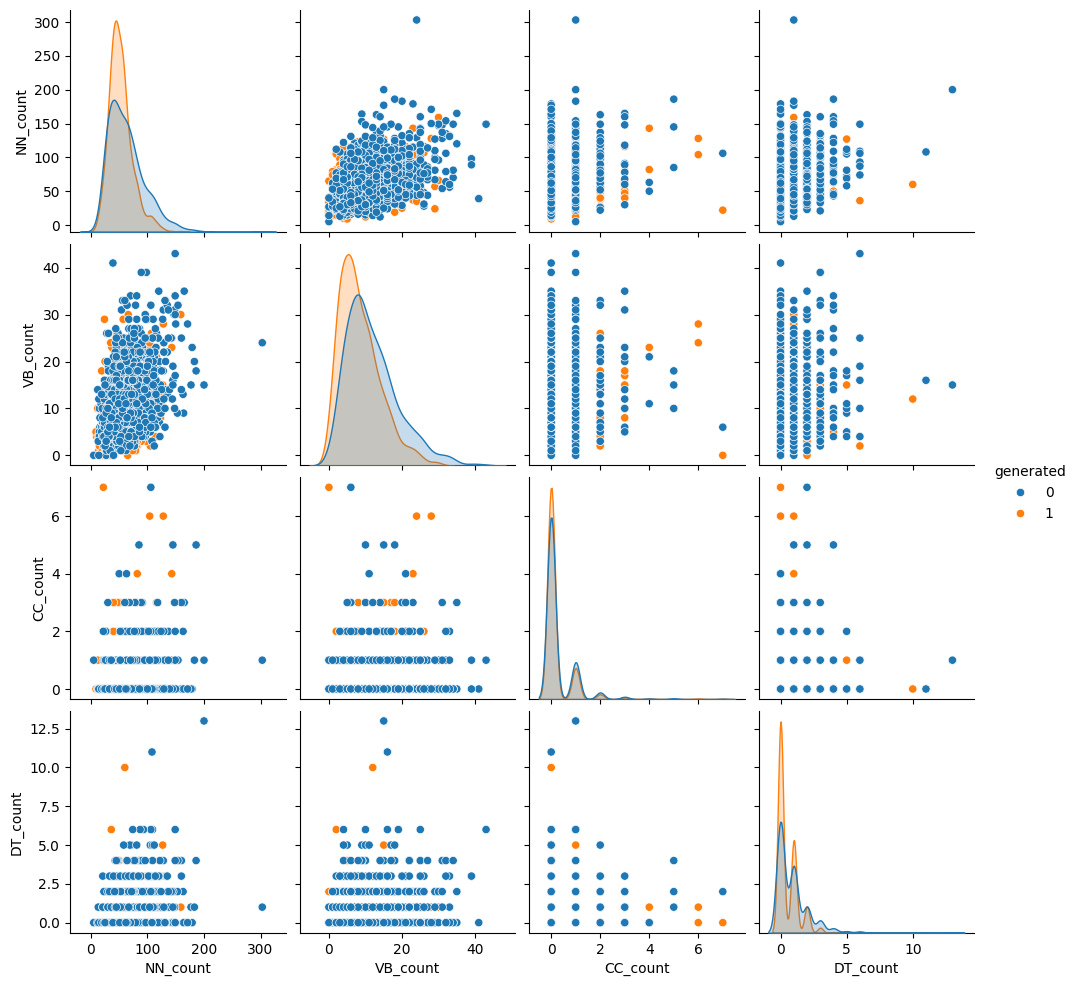

In [40]:
sns.pairplot(df[[ 'NN_count', 'VB_count','CC_count','DT_count','generated']], hue='generated')

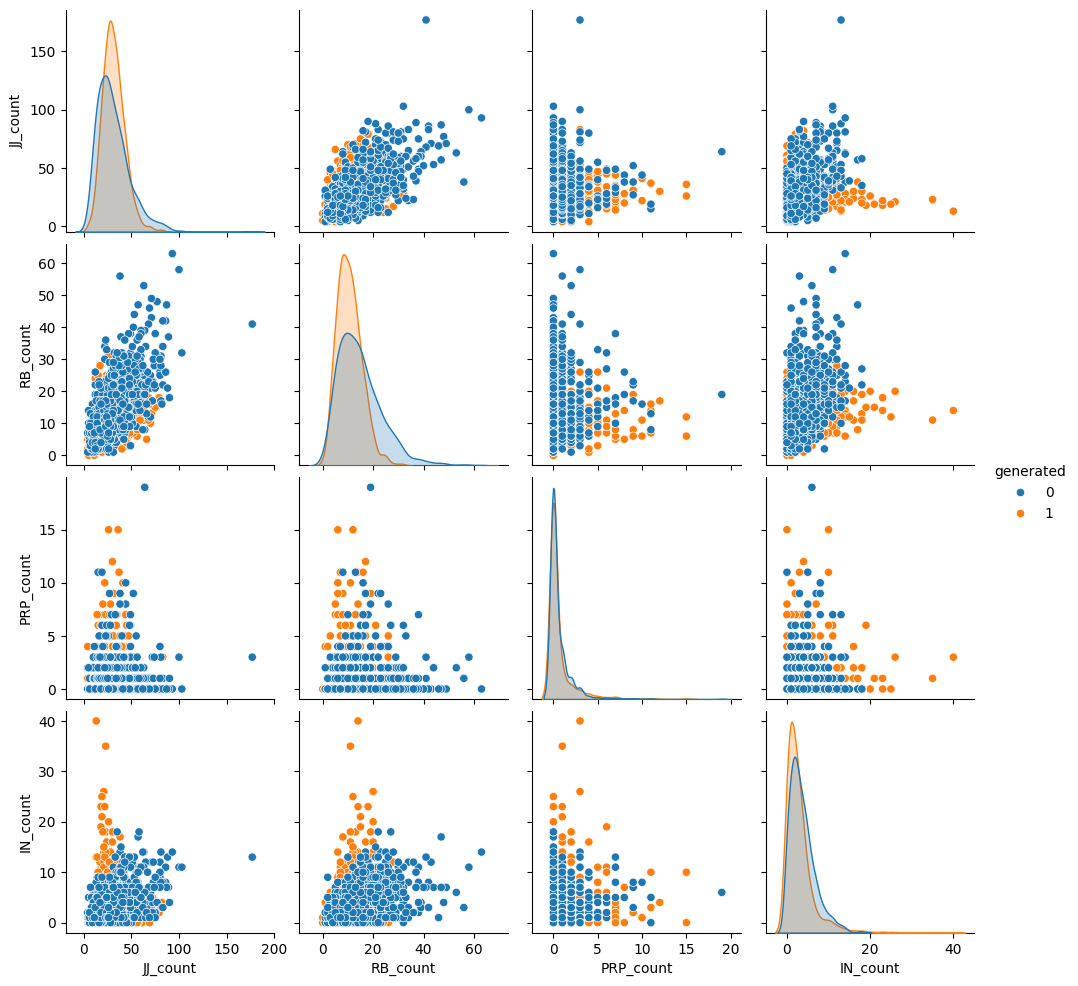

In [41]:
sns.pairplot(df[['JJ_count','RB_count','PRP_count','IN_count','generated']], hue='generated')

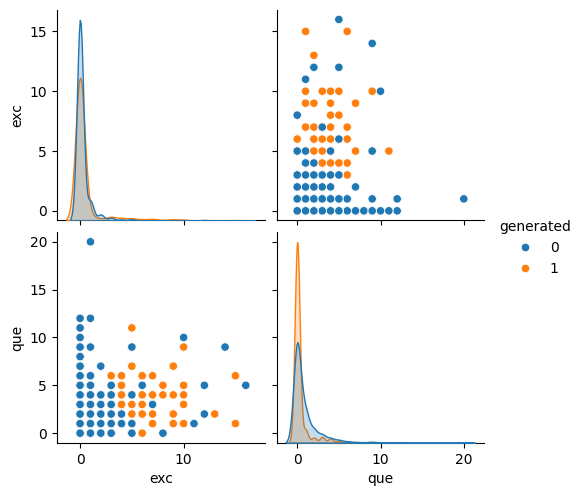

In [42]:
sns.pairplot(df[['exc','que','generated']], hue='generated')

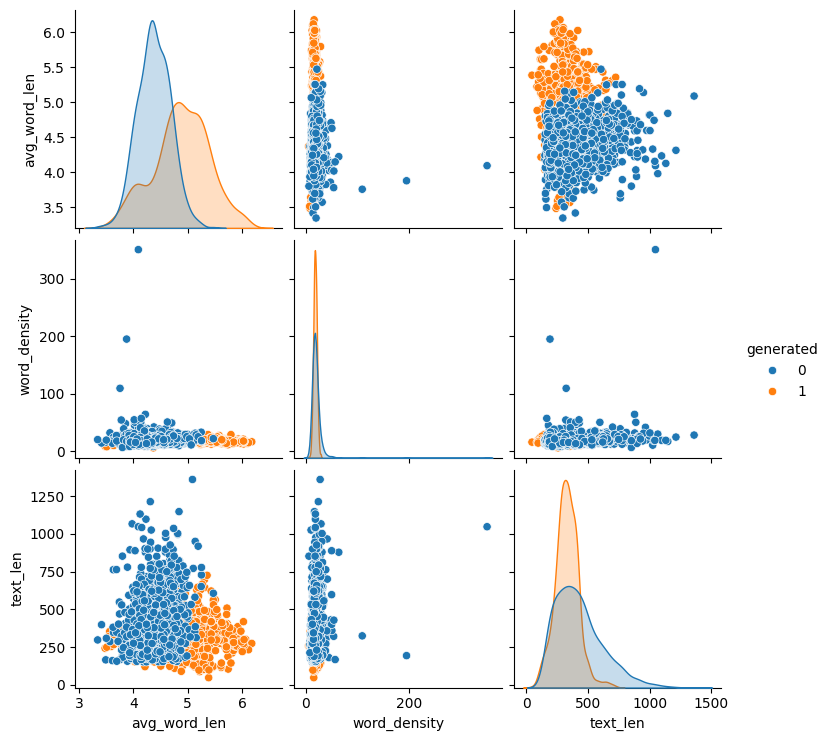

In [43]:
sns.pairplot(df[['avg_word_len','word_density','text_len','generated']], hue='generated')

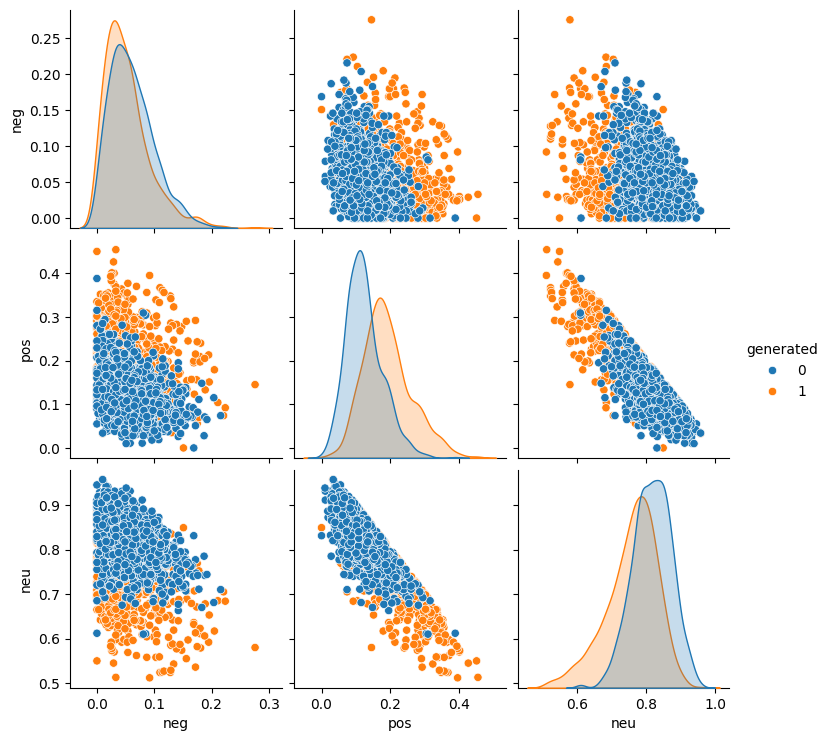

In [44]:
sns.pairplot(df[['neg','pos','neu','generated']], hue='generated')

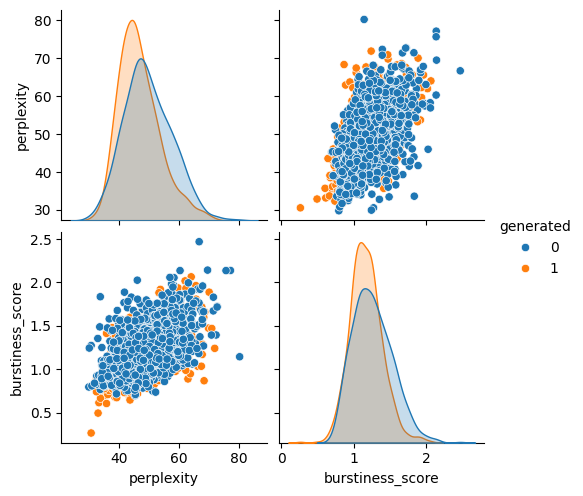

In [45]:
sns.pairplot(df[['perplexity','burstiness_score','generated']], hue='generated')

In [46]:
df.columns

Index(['text', 'generated', 'text_len', 'pre_processed', 'perplexity',
       'burstiness_score', 'NN_count', 'VB_count', 'JJ_count', 'RB_count',
       'PRP_count', 'IN_count', 'DT_count', 'CC_count', 'exc', 'que',
       'avg_word_len', 'word_density', 'neu', 'pos', 'neg'],
      dtype='object')

In [47]:
from transformers import BertTokenizer, TFBertModel

In [48]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [52]:
def get_bert_embeddings(text):
    tokens = tokenizer(text, return_tensors='tf', padding=True, truncation=True,max_length=20)
    outputs = model(**tokens)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.numpy()
    
df['bert_embeddings'] = df['text'].apply(get_bert_embeddings)

# Extract 768 features from each embedding and create separate columns
embedding_columns = [f'bert_feature_{i}' for i in range(768)]
df[embedding_columns] = pd.DataFrame(df['bert_embeddings'].apply(lambda x: x.flatten()).tolist(), index=df.index)

df = df.drop('bert_embeddings', axis=1)

C:\Users\HP\AppData\Local\Temp\ipykernel_9884\3344170717.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['bert_embeddings'] = df['text'].apply(get_bert_embeddings)


In [55]:
df.head()

,text,generated,text_len,pre_processed,perplexity,burstiness_score,NN_count,VB_count,JJ_count,RB_count,...,bert_feature_758,bert_feature_759,bert_feature_760,bert_feature_761,bert_feature_762,bert_feature_763,bert_feature_764,bert_feature_765,bert_feature_766,bert_feature_767
0,"Hey, it's me, your average 8th grade student! ...",1,239,"hey , it 's me , your averag 8th grade student...",47.479186,1.058331,36,7,16,14,...,0.061896,-0.218190,0.092297,-0.210459,0.311293,-0.058410,-0.434797,-0.074207,0.474859,0.651686
1,"Dear Senator,\n\nI am writing to you today to ...",1,497,"dear senat , i am write to you today to expres...",65.827761,1.727463,52,5,41,9,...,-0.022862,-0.313307,0.020141,-0.417276,0.405794,-0.149345,-0.068012,-0.380423,0.050273,0.571146
2,"[Student’s Name]\n[Address]\n[City, State ZIP ...",1,326,"[ student ’ s name ] [ address ] [ citi , stat...",49.106882,1.410586,41,10,31,4,...,0.327467,-0.172478,-0.210512,-0.213805,0.031715,0.336890,-0.072294,-0.550430,0.152579,0.598760
3,"Dear Senator,\n\nI am writing to you today to ...",1,363,"dear senat , i am write to you today to expres...",54.272492,1.313940,50,9,33,9,...,-0.059045,-0.262758,0.143747,-0.333160,0.215804,0.086584,-0.096567,-0.367934,0.153899,0.713077
4,Imagine going to school every day to learn an...,1,396,imagin go to school everi day to learn and exp...,45.519948,1.219632,72,11,37,16,...,0.050263,-0.483884,0.115261,0.013532,-0.265173,0.170386,-0.019858,-0.302337,0.476817,0.478213


In [57]:
exclude_columns = ['generated', 'text', 'pre_processed']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(exclude_columns, axis=1),  # Exclude specified columns
    df['generated'],
    test_size=0.2,
    random_state=42
)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train,y_train=df.drop('generated',axis=1),df['generated']

In [ ]:
# temp=test_data.sample(400,random_state=12)

In [ ]:
# X_test,y_test=temp.drop('generated',axis=1),temp['generated']

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9225

In [61]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.9275